### Downsample specsim output to log-10 A wavelength grid for eBOSS

Notes: 
- need to update eBOSSConfigData nb on specsim sdss-branch to make sure padding on throughput data is done correctly
- change `b_loglam.npy` and `r_loglam.npy` to be the average over all fibers over 20 plates and add to sdss-branch
- question about conditions on fwhm_resolution and neff_spatial in `camera.py`
- need to update downsampling to be applied to columns returned by `simulator.simulate()` 
- do I need to do anything to what's returned by `simulator.simulated`?

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import specsim.simulator
import astropy
import scipy

In [8]:
simulator = specsim.simulator.Simulator('eboss', num_fibers=200)
simulator.atmosphere
#simulator.instrument.fast_fiber_acceptance
simulator.simulate()

blue_output = simulator.camera_output[0]
red_output = simulator.camera_output[1]

sim = simulator.simulated

b_wlen, r_wlen = blue_output['wavelength'], red_output['wavelength']
b_flux, r_flux = blue_output['observed_flux'], red_output['observed_flux']

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


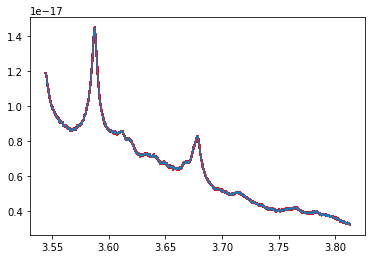

In [17]:
plt.plot(np.log10(b_wlen), b_flux, 'r-', alpha=0.3)
plt.plot(simulator.camera_output[2]['wavelength'], 
         simulator.camera_output[2]['observed_flux'][:,0])
plt.show()

In [5]:
eboss_wlen = np.load('b_loglam.npy')

### Test cases for resampled functions (sanity check)

In [4]:
def resample_binned(edges_out, edges_in, hist_in, axis=-1, zero_pad=True):
    """Flux conserving linear resampler of binned data.
    Parameters
    ----------
    edges_out : array
        1D array of M >= 2 output bin edges, in increasing order.
    edges_in : array
        1D array of N >= 2 input bin edges, in increasing order.
    hist_in : array
        Array with N-1 input bin values indexed by the specified axis.
    axis : int
        Axis of hist_in used to index input histogram values.
    zero_pad : bool
        When True, allow the output edges to extend beyond the input
        edges and assume that the input histogram is zero outside of
        its extent.  When False, raises a ValueError if extrapolation
        would be required.
    Returns
    -------
    array
        1D array of M-1 resampled bin values.
    """
    # Check input 1D arrays.
    edges_out = np.asarray(edges_out)
    edges_in = np.asarray(edges_in)
    if edges_out.ndim != 1:
        raise ValueError('Expected 1D edges_out.')
    if edges_in.ndim != 1:
        raise ValueError('Expected 1D edges_in.')
    if len(edges_out) < 2:
        raise ValueError('Need at least one output bin.')
    if len(edges_in) < 2:
        raise ValueError('Need at least one input bin.')
    binsize_out = np.diff(edges_out)
    if np.any(binsize_out <= 0):
        raise ValueError('Expecting increasing edges_out.')
    binsize_in = np.diff(edges_in)
    if np.any(binsize_in <= 0):
        raise ValueError('Expecting increasing edges_in.')
    if not zero_pad and ((edges_out[0] < edges_in[0]) or
                         (edges_out[-1] > edges_in[-1])):
        raise ValueError(
            'Ouput bins extend beyond input bins but zero_pad is False.')
    if (edges_out[0] >= edges_in[-1]) or (edges_out[-1] <= edges_in[0]):
        raise ValueError('Input and output bins do not overlap.')
    # Check input histogram(s) and put index in axis 0. Note that we
    # use moveaxis instead of rollaxis since it is easier to invert.
    hist_in = np.asarray(hist_in)
    hist_in_rolled = np.moveaxis(hist_in, axis, 0)
    if len(hist_in_rolled) != len(edges_in) - 1:
        raise ValueError(
            'Unexpected length of hist_in along axis {}.'.format(axis))
    # Align output edges to input edges.
    idx = np.searchsorted(edges_in, edges_out)
    # Loop over output bins.
    nin = len(edges_in) - 1
    nout = len(edges_out) - 1
    hist_out_rolled_shape = (nout,) + hist_in_rolled.shape[1:]
    hist_out_rolled = np.zeros(hist_out_rolled_shape)
    hi = idx[0]
    for i in range(nout):
        lo = hi
        hi = idx[i + 1]
        if (lo > nin) or (hi == 0):
            # This bin does not overlap the input.
            continue
        if lo == hi:
            # Output bin is fully embedded within an input bin:
            # give it a linear share.
            hist_out_rolled[i] = (
                binsize_out[i] / binsize_in[lo - 1] * hist_in_rolled[lo - 1])
            continue
        # Calculate fraction of first input bin overlapping this output bin.
        if lo > 0:
            hist_out_rolled[i] += (
                hist_in_rolled[lo - 1] / binsize_in[lo - 1] * (
                    edges_in[lo] - edges_out[i]))
        # Calculate fraction of last input bin overlaping this output bin.
        if hi <= nin:
            hist_out_rolled[i] += (
                hist_in_rolled[hi - 1] / binsize_in[hi - 1] * (
                    edges_out[i + 1] - edges_in[hi - 1]))
        # Add input bins fully contained within this output bin.
        if hi > lo + 1:
            hist_out_rolled[i] += np.sum(hist_in_rolled[lo:hi - 1], axis=0)
    # Return our unrolled output histogram.
    return np.moveaxis(hist_out_rolled, axis, 0)

In [34]:
dat = np.random.normal(loc=0, scale=1.0, size=100)
edges_in = np.arange(-3,4,1)
hist_in, _ = np.histogram(dat, edges_in)
edges_out = np.arange(-3,4,2)

In [35]:
hist_out = resample_binned(edges_out, edges_in, hist_in)

In [40]:
mdpt_in = 0.5 * (edges_in[1:] + edges_in[:-1])

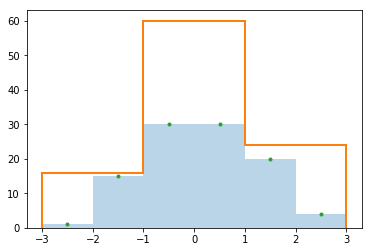

In [46]:
plt.hist(dat, bins=edges_in, alpha=0.3)
plt.hist(dat, bins=edges_out, histtype='step', lw=2)
plt.plot(mdpt_in, hist_in, '.')
plt.show()

Good - works as we would expect. Now I want to write my own downsampling function, do it the long way first so that I understand each step of what is going on. After this I will verify that I get the same result using `skysim.utils.resample_density()` then `skysim.utils.resample_binned()`. 

The first thing we need to do is to convert from flux density to counts. We do this by multiplying the flux by the bin width. Create `b_edges` so that the midpoint of each bin is centered on the values `b_wlen`.

Note: some of the `b_flux` and `r_flux` values are nan's ... need to look into this (maybe has to do with how throughput is calculated for wavelength values that fall outside of the wavelength grid for each camera?)

In [12]:
def centers_to_edges(centers, kind='cubic'):
    """Calculate bin edges from bin centers.
    Edges are calculated with interpolation (or extrapolation on the edges)
    from integer to half-integer indices.
    Parameters
    ----------
    centers : array
        1D array of N increasing center values with at least 2 values.
    kind : str or int
        Passed to :func:`scipy.interpolate.interp1d`. When N < 4,
        'linear' is always used.
    Returns
    -------
    array
        1D array of N+1 increasing bin edge values.
    """
    centers = np.asarray(centers)
    if len(centers.shape) != 1:
        raise ValueError('Expected 1D array of centers.')
    if len(centers) < 2:
        raise ValueError('Need at least 2 centers.')
    elif len(centers) < 4:
        kind = 'linear'
    if not np.all(np.diff(centers) > 0):
        raise ValueError('Expected increasing center values.')

    center_idx = np.arange(len(centers))
    interpolator = scipy.interpolate.interp1d(
        center_idx, centers, fill_value='extrapolate', copy=False,
        assume_sorted=True, kind=kind)

    edge_idx = np.arange(len(centers) + 1.) - 0.5
    return interpolator(edge_idx)

In [38]:
def resample_density(x_out, x_in, y_in, axis=-1, zero_pad=True):
    """Flux conserving linear resampling of density samples.
    By "density" we mean that the integral of y(x) is the conserved flux.
    This function is just a wrapper around :func:`resample_binned` that:
     - Estimates input bin edges.
     - Multiplies each density y(x[i]) by the bin width to obtain bin contents.
     - Resamples the binned data.
     - Divides output bin values by output bin widths to obtain densities.
    The special case of a single output sample location is handled with linear
    interpolation of the input densities, so is not really flux conserving but
    probably what you want in this case.
    Parameters
    ----------
    x_out : array
        1D array of M >= 1 output sample locations.
    x_in : array
        1D array of N >= 2 input sample locations.
    y_in : array
        Array of N input sample densities indexed by the specified axis.
    axis : int
        Axis of y_in used to index input density values.
    zero_pad : bool
        When True, allow the output edges to extend beyond the input
        edges and assume that the input histogram is zero outside of
        its extent.  When False, raises a ValueError if extrapolation
        would be required.
    Returns
    -------
    array
        1D array of M output densities.
    """
    x_in = np.asarray(x_in)
    x_out = np.asarray(x_out)
    y_in = np.asarray(y_in)
    if len(x_out.shape) == 0 or len(x_out) == 1:
        # Resampling to a single value.
        if not zero_pad and ((x_out < np.min(x_in)) or (x_out > np.max(x_in))):
            raise ValueError(
                'Cannot resample outside range when zero_pad is False.')
        # Linearly interpolate x_out in (x_in, y_in).
        return np.interp(x_out, x_in, y_in, left=0., right=0.)
    edges_out = centers_to_edges(x_out)
    edges_in = centers_to_edges(x_in)
    dx_shape = np.ones(y_in.ndim, int)
    dx_shape[axis] = -1
    hist_in = y_in * np.diff(edges_in).reshape(dx_shape)
    print(hist_in.shape)
    hist_out = resample_binned(edges_out, edges_in, hist_in, axis, zero_pad)
    print(hist_out.shape)
    return hist_out / np.diff(edges_out).reshape(dx_shape)

In [39]:
flux_density_in = b_flux
x_in = b_wlen
x_out = 10 ** eboss_wlen

In [40]:
output = resample_density(x_out, x_in, flux_density_in, axis=-1, zero_pad=True)

(6000, 6000)
(6000, 4128)


In [30]:
np.sum(output), np.sum(b_flux)

(9.964326468798468e-11, 3.622406930230696e-14)

In [31]:
# Why does the output have shape (6000,4128)
output.shape

(6000, 4128)

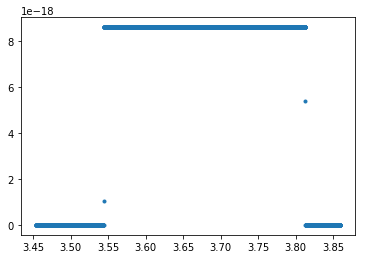

In [49]:
plt.plot(eboss_wlen, output[1000,:], '.')
plt.show()

In [12]:
## Bin width
b_diff = np.diff(b_wlen)
print(np.all(b_diff[0] == b_diff))
b_diff = b_diff[0]

True


In [13]:
## Define nominal bin edges
b_edges = b_wlen - (0.5 * b_diff)
b_edges = np.append(b_edges, b_edges[-1] + b_diff)
b_edges = np.log10(b_edges)

In [17]:
b_counts = b_flux * b_diff
## b_counts, b_edges is our simulation histogram

In [18]:
## Define eBOSS bin edges
eboss_wlen = np.load('b_loglam.npy')
eboss_diff = np.diff(eboss_wlen)
eboss_diff_app = np.append(eboss_diff, eboss_diff[-1])
eboss_edges = eboss_wlen - (0.5 * eboss_diff_app)
eboss_edges = np.append(eboss_edges, eboss_edges[-1] + eboss_diff_app[-1])

In [19]:
idx_in_eboss = np.searchsorted(eboss_edges, b_edges)

In [20]:
output_hist = np.zeros_like(eboss_wlen)
flux_right = 0
prev_idx = -1

for i in range(len(idx_in_eboss) - 1):
    if np.isnan(output_hist[idx_in_eboss[i]]):
        print(i)
    output_hist[idx_in_eboss[i] - 1] += flux_right
    if prev_idx == idx_in_eboss[i+1]:
        output_hist[prev_idx - 1] += b_counts[i]
    else:
        diff = idx_in_eboss[i+1] - idx_in_eboss[i]
        if diff == 0:
            output_hist[idx_in_eboss[i] - 1] += b_counts[i]
            flux_right = 0
            prev_idx = idx_in_eboss[i]
        elif diff > 0:
            left = (eboss_edges[idx_in_eboss[i]] - b_edges[i]) / (b_edges[i+1] - b_edges[i])
            right = 1 - left
            flux_left = left * b_counts[i]
            flux_right = right * b_counts[i]
            #assert (flux_right + flux_left) == b_counts[i]
            output_hist[idx_in_eboss[i] - 1] += flux_left

In [21]:
assert np.allclose(np.sum(output_hist), np.sum(b_counts))

In [22]:
fs = 14

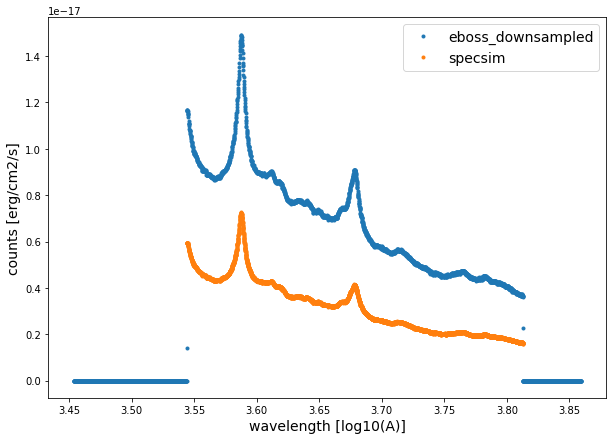

In [23]:
plt.figure(figsize=(10,7))
plt.plot(eboss_wlen, output_hist, '.', label='eboss_downsampled')
plt.plot(np.log10(b_wlen), b_counts, '.', label='specsim')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('counts [erg/cm2/s]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

Makes sense that it conserves flux even though it has higher counts at each wavelength because the wavelength grid is more sparse for the downsampled curve (specsim is more densely sampled).

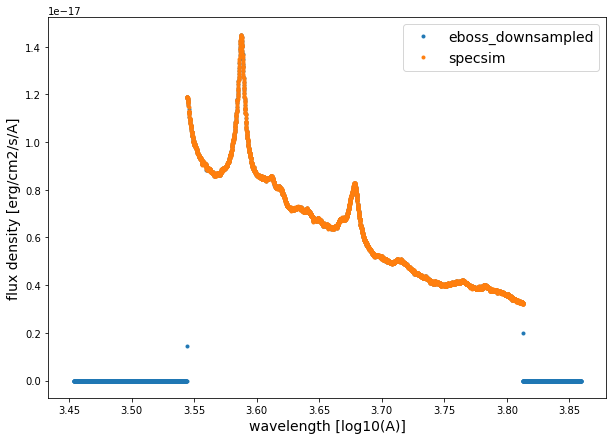

In [24]:
plt.figure(figsize=(10,7))
plt.plot(eboss_wlen, output_hist / (np.diff(10 ** eboss_edges)), '.', label='eboss_downsampled')
plt.plot(np.log10(b_wlen), b_flux, '.', label='specsim')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

Need to exclude wavelengths where there is no flux data in downsampled grid. I do this in the function below.

### Wrap everything into a single function

In [7]:
def downsample_to_eboss(wavelength_out, wavelength_in, flux_in):
    
    ## Get nominal bin width
    diff_in = np.diff(wavelength_in)
    ## Check that nominal grid is equally spaced 
    assert np.allclose(diff_in[0], diff_in, atol=0.0, rtol=1e-5)
    diff_in = diff_in[0]
    
    ## Define nominal bin edges
    edges_in = wavelength_in - (0.5 * diff_in)
    edges_in = np.append(edges_in, edges_in[-1] + diff_in)
    edges_in = np.log10(edges_in)
    
    ## Define output bin edges
    diff_out = np.diff(wavelength_out)
    diff_out = np.append(diff_out, diff_out[-1])
    edges_out = wavelength_out - (0.5 * diff_out)
    edges_out = np.append(edges_out, edges_out[-1] + diff_out[-1])
    edges_out = edges_out[::10]
    
    edges_in = np.around(edges_in, decimals=5)
    edges_out = np.around(edges_out, decimals=5)
    
    ## Check that both grids are strictly increasing
    assert np.all(edges_out == np.sort(edges_out))
    assert np.all(edges_in == np.sort(edges_in))
    ## Check that output grid covers the range of input grid 
    ## This is a necessary condition for flux conservation.
    assert edges_out[0] <= edges_in[0]
    assert edges_out[-1] >= edges_in[-1]
    
    ## Find index in out_edges where each element in in_edges 
    ## would fall in out_edges
    idx_in_out = np.searchsorted(edges_out, edges_in)
        
    ## Convert from flux density (per unit Angstrom) to flux (counts)
    ## First set nan elements to zero - this is temporary. Need to fix this.
    flux_in[np.isnan(flux_in)] = 0.0
    hist_in = flux_in * diff_in
    
    
    hist_out = np.zeros(len(edges_out) - 1)
    flux_right = 0
    prev_idx = -1

    for i in range(len(idx_in_out) - 1):
        #if np.isnan(hist_out[idx_in_out[i]]):
         #   print(i)
        hist_out[idx_in_out[i] - 1] += flux_right
        if prev_idx == idx_in_out[i+1]:
            hist_out[prev_idx - 1] += hist_in[i]
        else:
            diff = idx_in_out[i+1] - idx_in_out[i]
            if diff == 0:
                hist_out[idx_in_out[i] - 1] += hist_in[i]
                flux_right = 0
                prev_idx = idx_in_out[i]
            elif diff > 0:
                left = (edges_out[idx_in_out[i]] - edges_in[i]) / (edges_in[i+1] - edges_in[i])
                right = 1 - left
                flux_left = left * hist_in[i]
                flux_right = right * hist_in[i]
                assert np.allclose((flux_right + flux_left), hist_in[i])
                hist_out[idx_in_out[i] - 1] += flux_left

    ## Check if flux is conserved
    assert np.allclose(np.sum(hist_out), np.sum(hist_in))
    #return(hist_out, edges_out)
    
    ## Convert back from counts to flux density
    flux_out = hist_out / (np.diff(10 ** edges_out))
    ## Only return values within range of simulation wavelength grid
    start = idx_in_out[0]
    stop = idx_in_out[-1]
    return(edges_out[start:stop], flux_out[start:stop-1])

#### Sanity checks from an earlier version of the downsampling function

In [485]:
test_eboss_counts, test_eboss_grid = downsample_to_eboss(eboss_wlen, b_wlen, b_flux)
np.all(test_eboss_counts == output_hist), np.all(test_eboss_grid == eboss_edges)

(True, True)

In [141]:
test_eboss_edges, test_eboss_flux = downsample_to_eboss(eboss_wlen, b_wlen, b_flux)
np.all(test_eboss_flux == output_hist / (np.diff(10 ** eboss_edges)))

True

## Test to see if it's working properly

In [5]:
abs_base_path = '/Users/belaabolfathi/desi/code/specsim/specsim/data/'

In [24]:
eboss_r_wlen = np.log10(astropy.table.Table.read(abs_base_path+'sdss/eboss-red.fits', 
                                                 format='fits')['wavelength'])
eboss_r_edges, eboss_r_flux = downsample_to_eboss(eboss_r_wlen, r_wlen, r_flux)

eboss_b_wlen = np.log10(astropy.table.Table.read(abs_base_path+'sdss/eboss-blue.fits', 
                                                 format='fits')['wavelength'])
eboss_b_edges, eboss_b_flux = downsample_to_eboss(eboss_b_wlen, b_wlen, b_flux)
r_mdpt = 0.5 * (eboss_r_edges[1:] + eboss_r_edges[:-1])
b_mdpt = 0.5 * (eboss_b_edges[1:] + eboss_b_edges[:-1])

In [61]:
eboss_b_edges, eboss_b_source_electrons = downsample_to_eboss(eboss_b_wlen, b_wlen, blue_output['num_source_electrons'])

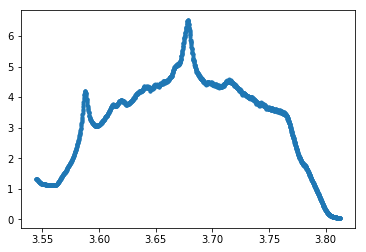

In [63]:
plt.plot(b_mdpt, eboss_b_source_electrons, '.')
plt.show()

### Flux density

In [8]:
eboss_r_wlen = np.log10(astropy.table.Table.read(abs_base_path+'sdss/eboss-red.fits', 
                                                 format='fits')['wavelength'])
eboss_r_wlen, eboss_r_flux = downsample_to_eboss(eboss_r_wlen, r_wlen, r_flux)

eboss_b_wlen = np.log10(astropy.table.Table.read(abs_base_path+'sdss/eboss-blue.fits', 
                                                 format='fits')['wavelength'])
eboss_b_wlen, eboss_b_flux = downsample_to_eboss(eboss_b_wlen, b_wlen, b_flux)

In [28]:
fs = 14

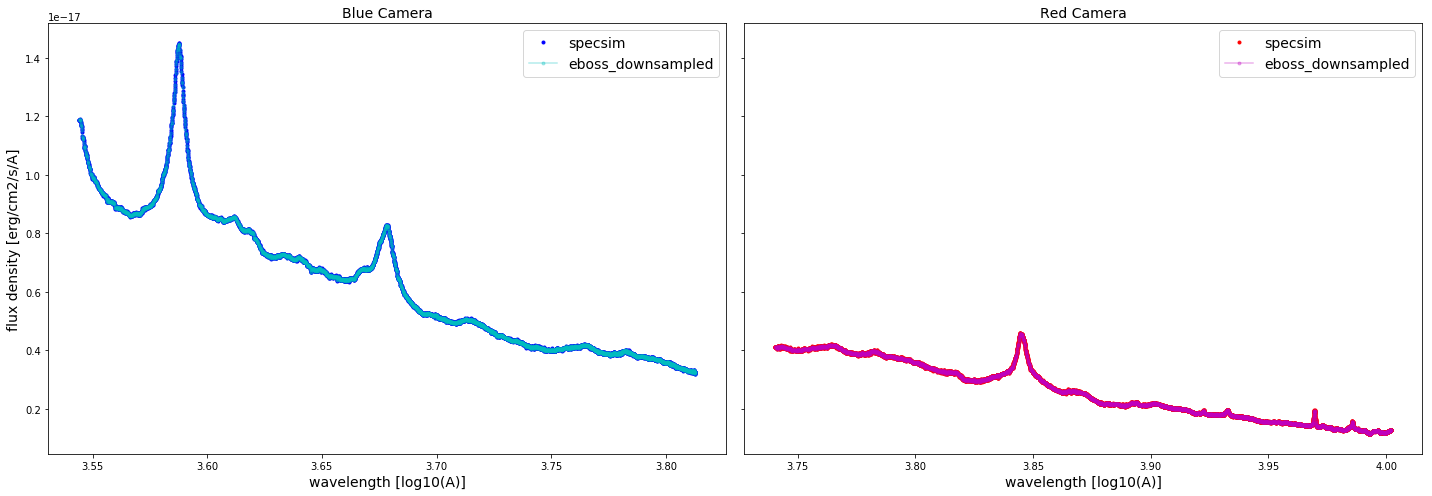

In [30]:
fig, axs = plt.subplots(1,2, figsize=(20,7), sharey=True)
axs = axs.ravel()

axs[0].plot(np.log10(b_wlen), b_flux, '.', c='b', label='specsim')
axs[0].plot(eboss_b_wlen, eboss_b_flux, '.-', alpha=0.3, c='c', label='eboss_downsampled')
axs[0].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[0].set_ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
axs[0].set_title('Blue Camera', fontsize=fs)
axs[0].legend(fontsize=fs)

axs[1].plot(np.log10(r_wlen), r_flux, '.', c='r', label='specsim')
axs[1].plot(eboss_r_wlen, eboss_r_flux, '.-', alpha=0.3, c='m', label='eboss_downsampled')
axs[1].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[1].set_title('Red Camera', fontsize=fs)
axs[1].legend(fontsize=fs)

plt.tight_layout()
plt.show()

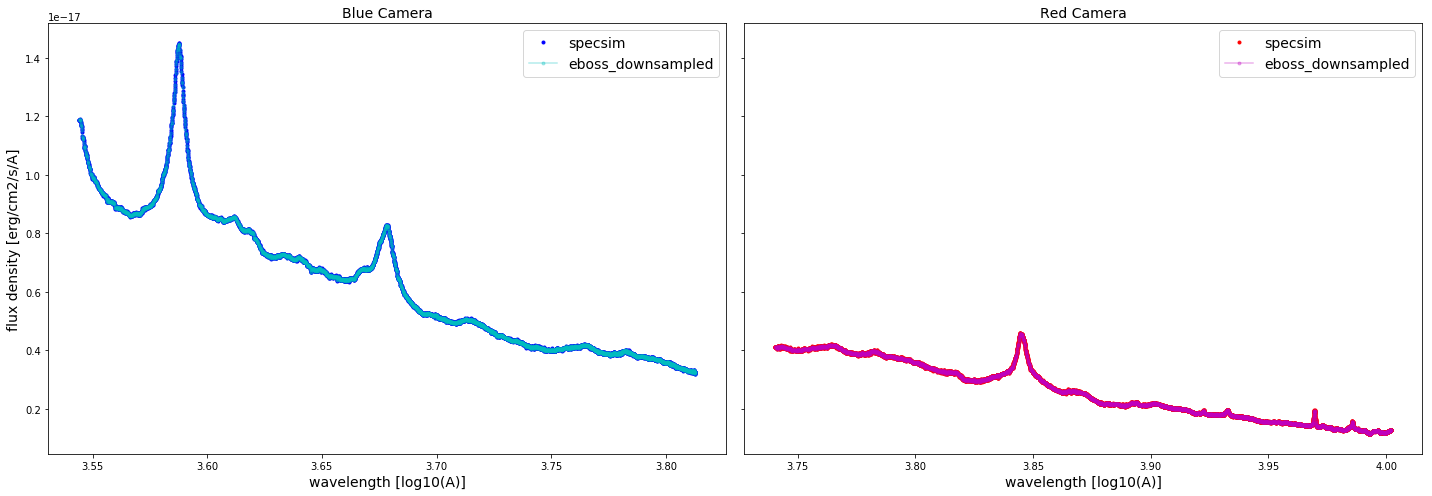

In [54]:
fig, axs = plt.subplots(1,2, figsize=(20,7), sharey=True)
axs = axs.ravel()

axs[0].plot(np.log10(b_wlen), b_flux, '.', c='b', label='specsim')
axs[0].plot(b_mdpt, eboss_b_flux, '.-', alpha=0.3, c='c', label='eboss_downsampled')
axs[0].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[0].set_ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
axs[0].set_title('Blue Camera', fontsize=fs)
axs[0].legend(fontsize=fs)

axs[1].plot(np.log10(r_wlen), r_flux, '.', c='r', label='specsim')
axs[1].plot(r_mdpt, eboss_r_flux, '.-', alpha=0.3, c='m', label='eboss_downsampled')
axs[1].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[1].set_title('Red Camera', fontsize=fs)
axs[1].legend(fontsize=fs)

plt.tight_layout()
plt.show()

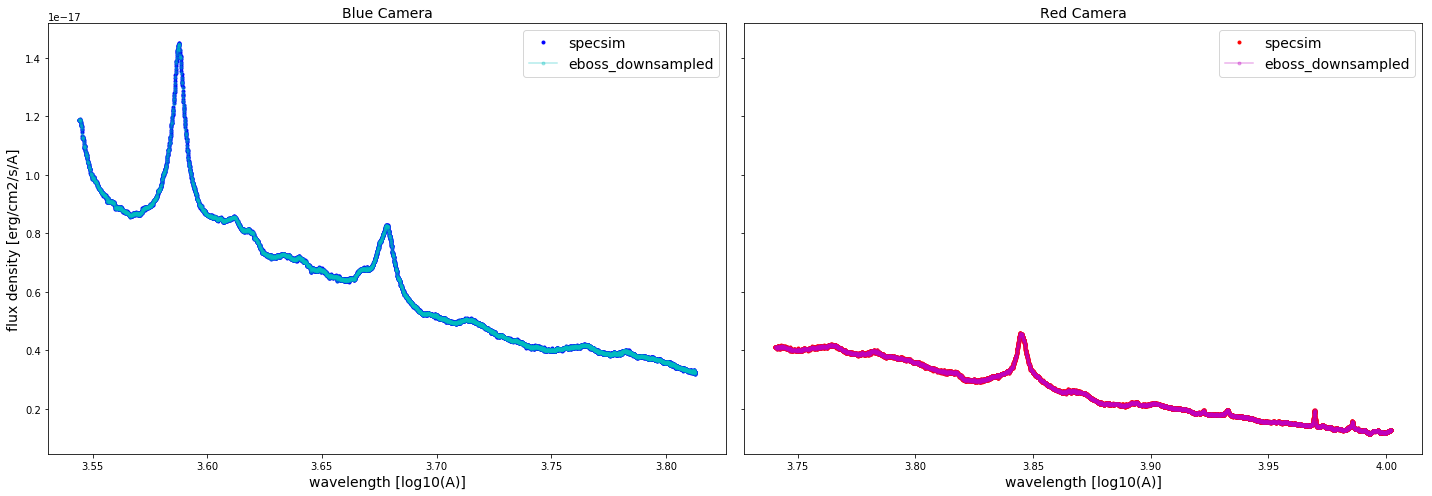

In [39]:
fig, axs = plt.subplots(1,2, figsize=(20,7), sharey=True)
axs = axs.ravel()

axs[0].plot(np.log10(b_wlen), b_flux, '.', c='b', label='specsim')
axs[0].plot(b_mdpt, eboss_b_flux, '.-', alpha=0.3, c='c', label='eboss_downsampled')
axs[0].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[0].set_ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
axs[0].set_title('Blue Camera', fontsize=fs)
axs[0].legend(fontsize=fs)

axs[1].plot(np.log10(r_wlen), r_flux, '.', c='r', label='specsim')
axs[1].plot(r_mdpt, eboss_r_flux, '.-', alpha=0.3, c='m', label='eboss_downsampled')
axs[1].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[1].set_title('Red Camera', fontsize=fs)
axs[1].legend(fontsize=fs)

plt.tight_layout()
plt.show()

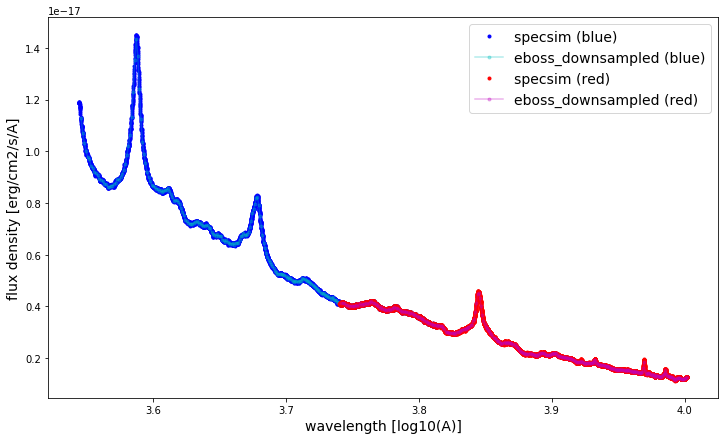

In [9]:
plt.figure(figsize=(12,7))
plt.plot(np.log10(b_wlen), b_flux, '.', c='b', label='specsim (blue)')
plt.plot(b_mdpt, eboss_b_flux, '.-', alpha=0.3, c='c', label='eboss_downsampled (blue)')
plt.plot(np.log10(r_wlen), r_flux, '.', c='r', label='specsim (red)')
plt.plot(r_mdpt, eboss_r_flux, '.-', alpha=0.3, c='m', label='eboss_downsampled (red)')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

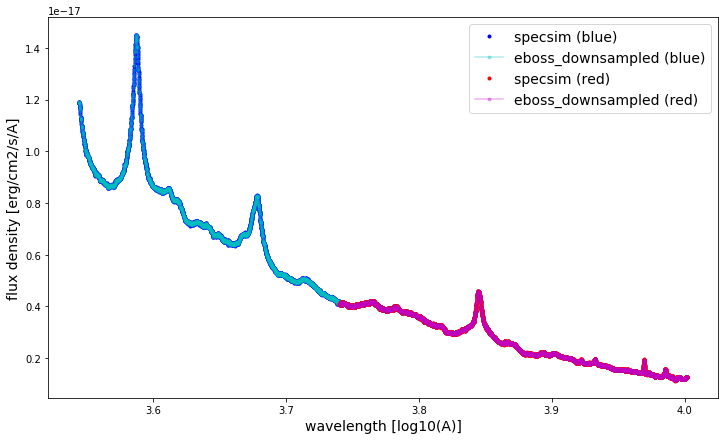

In [37]:
plt.figure(figsize=(12,7))
plt.plot(np.log10(b_wlen), b_flux, '.', c='b', label='specsim (blue)')
plt.plot(b_mdpt, eboss_b_flux, '.-', alpha=0.3, c='c', label='eboss_downsampled (blue)')
plt.plot(np.log10(r_wlen), r_flux, '.', c='r', label='specsim (red)')
plt.plot(r_mdpt, eboss_r_flux, '.-', alpha=0.3, c='m', label='eboss_downsampled (red)')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

## Is flux conserved?

In [10]:
print(np.allclose(np.sum(b_flux), np.sum(eboss_b_flux)))
print(np.allclose(np.sum(r_flux), np.sum(eboss_r_flux)))

True
True


In [30]:
eboss_b_out = np.load('mean_eboss_wlen_blue.npy')
eboss_r_out = np.load('mean_eboss_wlen_red.npy')

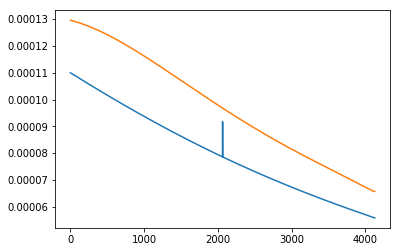

In [39]:
plt.plot(np.diff(eboss_r_out))
plt.plot(np.diff(eboss_b_out))

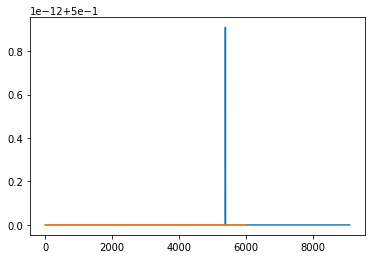

In [40]:
plt.plot(np.diff(r_wlen))
plt.plot(np.diff(b_wlen))

In [26]:
def downsample_to_eboss(wavelength_out, wavelength_in, flux_in):
    
    ## Get nominal bin width
    diff_in = np.diff(wavelength_in)
    ## Check that nominal grid is equally spaced 
    assert np.allclose(diff_in[0], diff_in, atol=0.0, rtol=1e-5)
    diff_in = diff_in[0]
    
    ## Define nominal bin edges
    edges_in = wavelength_in - (0.5 * diff_in)
    edges_in = np.append(edges_in, edges_in[-1] + diff_in)
    edges_in = np.log10(edges_in)
    
    ## Define output bin edges
    diff_out = np.diff(wavelength_out)
    diff_out = np.append(diff_out, diff_out[-1])
    edges_out = wavelength_out - (0.5 * diff_out)
    print(edges_out)
    edges_out = np.append(edges_out, edges_out[-1] + diff_out[-1])
    #edges_out = edges_out[::10]
    
    print(edges_out[-1], edges_in[-1])
    
    ## Check that both grids are strictly increasing
    assert np.all(edges_out == np.sort(edges_out))
    assert np.all(edges_in == np.sort(edges_in))
    ## Check that output grid covers the range of input grid 
    ## This is a necessary condition for flux conservation.
    assert edges_out[0] < edges_in[0]
    assert edges_out[-1] > edges_in[-1]
    
    ## Find index in out_edges where each element in in_edges 
    ## would fall in out_edges
    idx_in_out = np.searchsorted(edges_out, edges_in)
        
    ## Convert from flux density (per unit Angstrom) to flux (counts)
    ## First set nan elements to zero - this is temporary. Need to fix this.
    flux_in[np.isnan(flux_in)] = 0.0
    hist_in = flux_in * diff_in
    
    
    hist_out = np.zeros(len(edges_out) - 1)
    flux_right = 0
    prev_idx = -1

    for i in range(len(idx_in_out) - 1):
        #if np.isnan(hist_out[idx_in_out[i]]):
         #   print(i)
        hist_out[idx_in_out[i] - 1] += flux_right
        if prev_idx == idx_in_out[i+1]:
            hist_out[prev_idx - 1] += hist_in[i]
        else:
            diff = idx_in_out[i+1] - idx_in_out[i]
            if diff == 0:
                hist_out[idx_in_out[i] - 1] += hist_in[i]
                flux_right = 0
                prev_idx = idx_in_out[i]
            elif diff > 0:
                left = (edges_out[idx_in_out[i]] - edges_in[i]) / (edges_in[i+1] - edges_in[i])
                right = 1 - left
                flux_left = left * hist_in[i]
                flux_right = right * hist_in[i]
                assert np.allclose((flux_right + flux_left), hist_in[i])
                hist_out[idx_in_out[i] - 1] += flux_left

    ## Check if flux is conserved
    assert np.allclose(np.sum(hist_out), np.sum(hist_in))
    #return(hist_out, edges_out)
    
    ## Convert back from counts to flux density (per Angstrom)
    flux_out = hist_out / (np.diff(10 ** edges_out))
    
    ## Only return values within range of simulation wavelength grid
    start = idx_in_out[0]
    stop = idx_in_out[-1]
    
    
    out_mdpt = 0.5 * (edges_out[1:] + edges_out[:-1])
    
    print(np.sum(flux_in), np.sum(flux_out), np.sum(flux_out[start:stop-1]))
    np.allclose(np.sum(flux_in), np.sum(flux_out[start:stop-1]))
    return(out_mdpt[start:stop-1], flux_out[start:stop-1])

In [14]:
r_mdpt_test, r_flux_test = downsample_to_eboss(eboss_r_out, r_wlen, r_flux)

[3.71199826 3.71210824 3.71221822 ... 4.04243833 4.04249419 4.04255004]
4.042605888581375 4.002163901082069
2.2405104279147936e-14 7.901199527150336e-15 7.897856736899888e-15


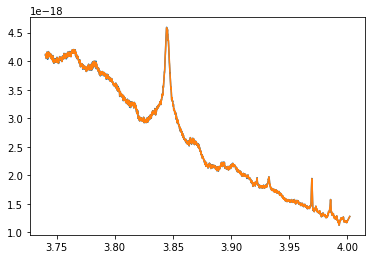

In [15]:
plt.plot(np.log10(r_wlen), r_flux)
plt.plot(r_mdpt_test, r_flux_test)
plt.show()

In [16]:
b_mdpt_test, b_flux_test = downsample_to_eboss(eboss_b_out, 
                                                b_wlen, b_flux)

[3.45888112 3.45901069 3.45914025 ... 3.86188778 3.86195352 3.86201927]
3.8620850061215712 3.8129100159032228
3.622406930230696e-14 1.686057327325309e-14 1.6856995601154613e-14


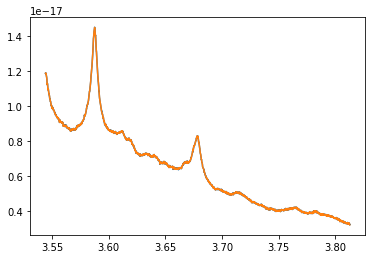

In [18]:
plt.plot(np.log10(b_wlen), b_flux)
plt.plot(b_mdpt_test, b_flux_test)
plt.show()

### Need to extend downsampling function to accomodate more than one fiber

In [6]:
import astropy.units as u

In [5]:
eboss_blue_output = simulator.camera_output[2]
eboss_red_output = simulator.camera_output[3]

In [65]:
num_fibers = 2

In [28]:
num_rows = len(eboss_blue_output['wavelength'])
shape = (num_fibers,)
column_args = dict(dtype=float, length=num_rows, shape=shape)
flux_unit = u.erg / (u.cm**2 * u.s * u.Angstrom)

In [19]:
table = astropy.table.Table(meta=dict(description='Specsim simulation results'))

In [23]:
table.add_column(astropy.table.Column(
            name='wavelength', data=eboss_blue_output['wavelength']))

In [29]:
table.add_column(astropy.table.Column(
            name='source_flux', unit=flux_unit, **column_args))

In [67]:
meta = dict(name='b', num_fibers=num_fibers)
table = astropy.table.Table(meta=meta)
## column_args defined earlier when generated simulated table
column_args['length'] = len(blue_output['wavelength'])
table.add_column(astropy.table.Column(
    name='wavelength', data=blue_output['wavelength']))
table.add_column(astropy.table.Column(
    name='num_source_electrons', **column_args))

Ok, but how is the data for each fiber stored in the output table?

In [51]:
simulator.simulated['num_source_photons']

5.905347914877457 .. 5.408781672279807
5.9054521670825695 .. 5.408975319467212
5.90598699751642 .. 5.4095633547232875
5.906091219299196 .. 5.409756984790726
5.906194862331675 .. 5.409950086528313
5.906299014586244 .. 5.410143656485012
5.906402588072354 .. 5.410336698073579
5.906937479010914 .. 5.410924840641346
5.907041566024807 .. 5.41111836335629
5.907145618241099 .. 5.4113118559828655
5.907249091602646 .. 5.411504820120158


In [55]:
simulator.instrument.photons_per_bin[:, np.newaxis].shape

(63001, 1)

In [56]:
simulator.atmosphere.surface_brightness[:, np.newaxis].shape

(63001, 1)

In [59]:
simulator.fiber_area.value

array([1.95116753, 1.95116753])

In [70]:
table['num_source_electrons'][:] = blue_output['flux_calibration'] * blue_output['num_source_electrons']

How is camera._output_slice made to handle multiple fibers?

• see `camera.downsample()`: It essentially selects rows from the data based on where `row_size > 0` (`self._output_slice`) which preserves axis=1 (fiber axis). Then it reshapes to the downsampled shape and sums over every `self._downsampling` number of values to give an output with shape (downsampled grid, num_fibers).

Set up a table that has shape `(len(wavelength_out), 2)`:

In [12]:
num_fibers = 2
num_rows = len(blue_output['wavelength'])
shape = (num_fibers,)
column_args = dict(dtype=float, length=num_rows, shape=shape)
flux_unit = u.erg / (u.cm**2 * u.s * u.Angstrom)

In [13]:
meta = dict(name='b', num_fibers=num_fibers)
table = astropy.table.Table(meta=meta)
table.add_column(astropy.table.Column(
    name='wavelength', data=blue_output['wavelength']))
table.add_column(astropy.table.Column(
    name='observed_flux', **column_args))

In [24]:
table['observed_flux'][:,0] = blue_output['observed_flux'][:,0]
table['observed_flux'][:,1] = blue_output['observed_flux'][:,0]

In [34]:
## This is the input to our downsampling algorithm
## wavelength_out = eboss_b_out
wave_in = table['wavelength']
data = table['observed_flux']

In [53]:
wlen, flux = downsample_to_eboss(eboss_b_out, wave_in, data)

In [54]:
flux.shape

(2754, 2)

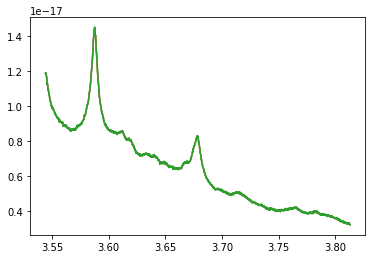

In [57]:
plt.plot(wlen, flux[:,0])
plt.plot(wlen, flux[:,1])
plt.plot(np.log10(blue_output['wavelength']), blue_output['observed_flux'])
plt.show()

In [52]:
def downsample_to_eboss(wavelength_out, wavelength_in, flux_in):
    
    num_fibers = flux_in.shape[1]
    
    ## Get nominal bin width
    diff_in = np.diff(wavelength_in)
    ## Check that nominal grid is equally spaced 
    assert np.allclose(diff_in[0], diff_in, atol=0.0, rtol=1e-5)
    diff_in = diff_in[0]
    
    ## Define nominal bin edges
    edges_in = wavelength_in - (0.5 * diff_in)
    edges_in = np.append(edges_in, edges_in[-1] + diff_in)
    edges_in = np.log10(edges_in)
    
    ## Define output bin edges
    diff_out = np.diff(wavelength_out)
    diff_out = np.append(diff_out, diff_out[-1])
    edges_out = wavelength_out - (0.5 * diff_out)
    edges_out = np.append(edges_out, edges_out[-1] + diff_out[-1])
    #edges_out = edges_out[::10]
        
    ## Check that both grids are strictly increasing
    assert np.all(edges_out == np.sort(edges_out))
    assert np.all(edges_in == np.sort(edges_in))
    ## Check that output grid covers the range of input grid 
    ## This is a necessary condition for flux conservation.
    assert edges_out[0] < edges_in[0]
    assert edges_out[-1] > edges_in[-1]
    
    ## Find index in out_edges where each element in in_edges 
    ## would fall in out_edges
    idx_in_out = np.searchsorted(edges_out, edges_in)
        
    ## Convert from flux density (per unit Angstrom) to flux (counts)
    ## First set nan elements to zero - this is temporary. Need to fix this.
    flux_in[np.isnan(flux_in)] = 0.0
    hist_in = flux_in * diff_in
        
    hist_out = np.zeros((len(edges_out) - 1, num_fibers))
    flux_right = 0
    prev_idx = -1

    for i in range(len(idx_in_out) - 1):
        #if np.isnan(hist_out[idx_in_out[i]]):
         #   print(i)
        hist_out[idx_in_out[i] - 1] += flux_right
        if prev_idx == idx_in_out[i+1]:
            hist_out[prev_idx - 1] += hist_in[i]
        else:
            diff = idx_in_out[i+1] - idx_in_out[i]
            if diff == 0:
                hist_out[idx_in_out[i] - 1] += hist_in[i]
                flux_right = 0
                prev_idx = idx_in_out[i]
            elif diff > 0:
                left = (edges_out[idx_in_out[i]] - edges_in[i]) / (edges_in[i+1] - edges_in[i])
                right = 1 - left
                flux_left = left * hist_in[i]
                flux_right = right * hist_in[i]
                assert np.allclose((flux_right + flux_left), hist_in[i])
                hist_out[idx_in_out[i] - 1] += flux_left

    ## Check if flux is conserved
    assert np.allclose(np.sum(hist_out), np.sum(hist_in))
    #return(hist_out, edges_out)
    
    ## Convert back from counts to flux density (per Angstrom)
    flux_out = hist_out / (np.diff(10 ** edges_out)[:, np.newaxis])
    
    ## Only return values within range of simulation wavelength grid
    start = idx_in_out[0]
    stop = idx_in_out[-1]
    
    
    out_mdpt = 0.5 * (edges_out[1:] + edges_out[:-1])
    
    np.allclose(np.sum(flux_in), np.sum(flux_out[start:stop-1]))
    return(out_mdpt[start:stop-1], flux_out[start:stop-1])